In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak
from numpy import random

In [2]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import backend as K

def custom_mse(y_true, y_pred):
    loss = K.square(y_pred - y_true)
    loss1 = loss[0]+loss[1]+loss[2]+loss[3]+loss[4]+loss[5]
    loss2 = loss[6]+loss[7]+loss[8]+loss[9]+loss[10]+loss[11]
    return K.switch(loss1<loss2 , lambda: loss1, lambda: loss2)

In [3]:
import logging

logging.basicConfig(level = logging.INFO)
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.info(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    logging.info(e)

In [4]:
data = np.load('./nsi_data/sample_nsi_regression_1e7_v1.npz')

data_selection = 1 # 0 for all, 1 for lowE(<5GeV), 2 for high(>5GeV)

if data_selection == 0:
    data_mid = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
elif data_selection == 1:
    data_mid = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])
elif data_selection == 2:
    data_mid = np.column_stack([data['ve_dune'][:,36:], data['vu_dune'][:,36:], data['vebar_dune'][:,36:], data['vubar_dune'][:,36:]])

In [5]:
data_test_mid = data_mid[-1]

In [6]:
N = 100000
data_create = random.poisson(data_test_mid, size = (N, len(data_test_mid)))

In [7]:
model_allparams = tf.keras.models.load_model('./models_PoissonTrain/nsi_degen_allparams_20_1_1.h5', compile=False)
model_allparams.summary()

Model: "Model_DNN_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BatchNormalization (BatchNor (None, 144)               576       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               74240     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 342,602
Trainable params: 342,314
Non-trainable params: 288
_________________________________________________________________


In [8]:
pre_create = model_allparams.predict(data_create)

In [9]:
pre_create[:1]

array([[8.674659 , 6.02786  , 5.4703503, 4.2697268, 5.7471266, 8.677628 ,
        6.0280247, 5.4697437, 4.2693157, 5.734934 ]], dtype=float32)

In [10]:
pre_create_theta23 = pre_create[:,0][:,np.newaxis]*5
pre_create_delta = (pre_create[:,1][:,np.newaxis]-5)*180
pre_create_theta23_2 = pre_create[:,5][:,np.newaxis]*5
pre_create_delta_2 = (pre_create[:,6][:,np.newaxis]-5)*180

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: No contour levels were found within the data range.


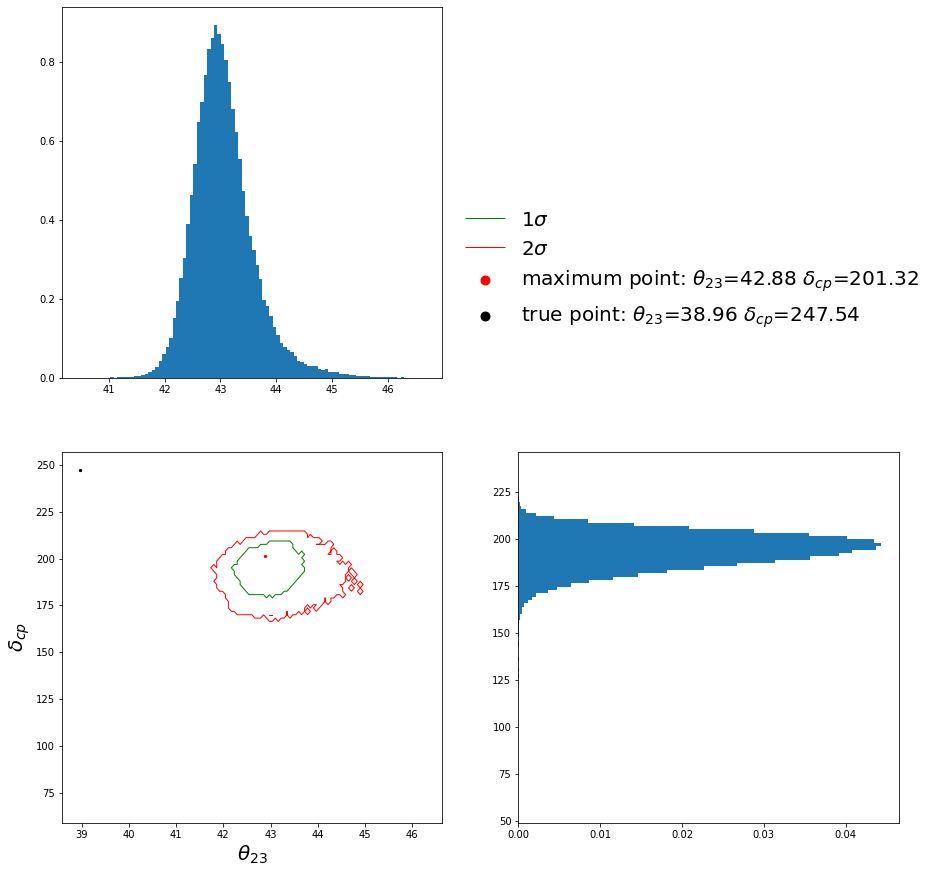

In [11]:
input_theta23 = pre_create_theta23
input_delta = pre_create_delta

bins_theta23, bins_delta = 100, 100
likeliregion, xedges, yedges = np.histogram2d(input_theta23[:,0], input_delta[:,0], bins = [bins_theta23,bins_delta])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

tot_event_num = sorted_list.sum()

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/tot_event_num >= 0.68:
        one_sigma_num = sorted_list[i]
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/tot_event_num >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis.hist(pre_create_theta23,density=1,bins=100)

plot_axis = plt.subplot(2,2,4)

plot_axis.hist(pre_create_delta,orientation="horizontal",density=1, bins=100)

plot_axis = plt.subplot(2,2,3)
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("1$\sigma$")
CS_2_sigma.collections[0].set_label("2$\sigma$")
plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]], c="r", s=5, label = "maximum point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))
plot_axis.scatter(data['theta23'][0], data['delta'][0], c="k", s=5, label = "true point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(data['theta23'][0], data['delta'][0]))

# DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("DUNE")
plot_axis.set_xlabel(r'$\theta_{23} $', fontsize=20)
plot_axis.set_ylabel(r'$\delta_{cp} $', fontsize=20)
# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: No contour levels were found within the data range.


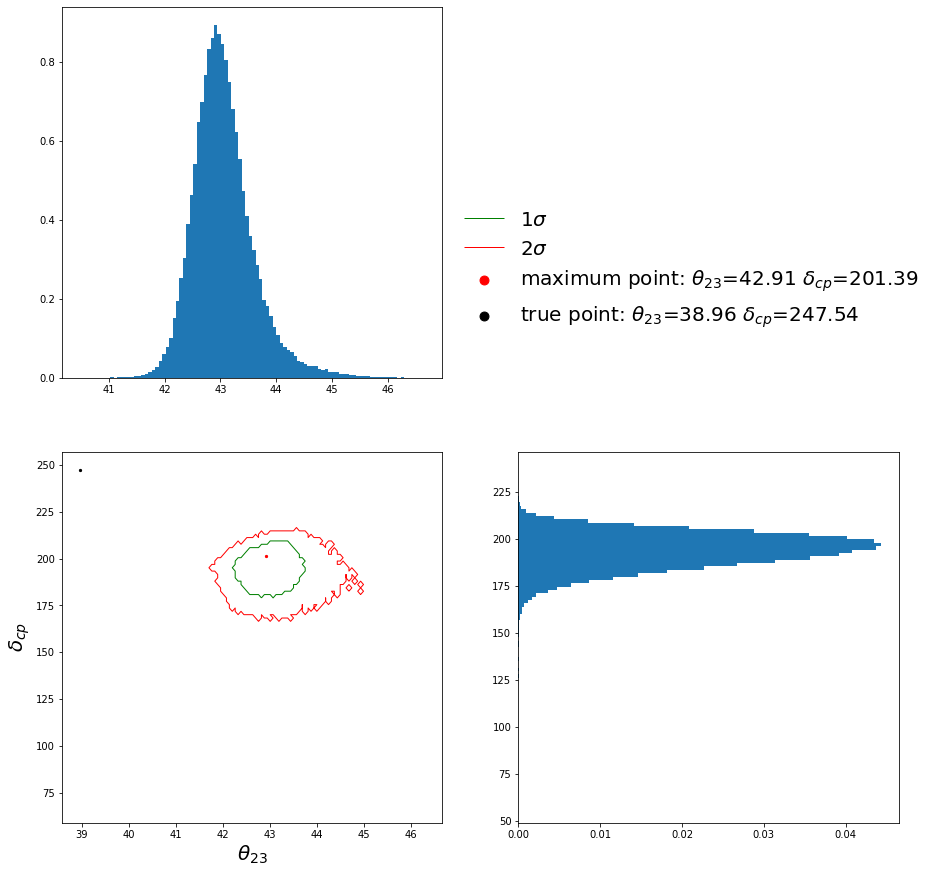

In [12]:
input_theta23 = pre_create_theta23_2
input_delta = pre_create_delta_2

bins_theta23 = 100
bins_delta = 100
likeliregion, xedges, yedges = np.histogram2d(input_theta23[:,0], input_delta[:,0], bins = [bins_theta23,bins_delta])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

tot_event_num = sorted_list.sum()

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/tot_event_num >= 0.68:
        one_sigma_num = sorted_list[i]
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/tot_event_num >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis.hist(pre_create_theta23,density=1,bins=100)

plot_axis = plt.subplot(2,2,4)

plot_axis.hist(pre_create_delta,orientation="horizontal",density=1, bins=100)

plot_axis = plt.subplot(2,2,3)
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("1$\sigma$")
CS_2_sigma.collections[0].set_label("2$\sigma$")
plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]], c="r", s=5, label = "maximum point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))
plot_axis.scatter(data['theta23'][0], data['delta'][0], c="k", s=5, label = "true point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(data['theta23'][0], data['delta'][0]))

# DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("DUNE")
plot_axis.set_xlabel(r'$\theta_{23} $', fontsize=20)
plot_axis.set_ylabel(r'$\delta_{cp} $', fontsize=20)
# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()

In [13]:
data_create = random.poisson(data_mid[9000000:])
data_predict = model_allparams.predict(data_create)

In [ ]:
data_predict = np.column_stack([data_predict[:,0],data_predict[:,1]*5,(data_predict[:,2]-5)*180,data_predict[:,3]-5,data_predict[:,4]-5,data_predict[:,5]-5,
                               data_predict[:,6],data_predict[:,7]*5,(data_predict[:,8]-5)*180,data_predict[:,9]-5,data_predict[:,10]-5,data_predict[:,11]-5])
pre_target = np.column_stack([data['theta13'][9000000:],data['theta23'][9000000:],data['delta'][9000000:],data['mumu'][9000000:],data['emu'][9000000:],data['etau'][9000000:]])

In [ ]:
labels = ['theta13', 'theta23 (degree)', 'deltacp (degree)', 'mumu', 'emu', 'etau']
for i in range(6):
    plt.hist(data_predict[:, i], histtype='step', density=True, bins=100)
    plt.hist(data_predict[:, i+6], histtype='step', density=True, bins=100)
    plt.hist(pre_target[:, i], histtype='step', density=True,  bins=100)
    plt.xlabel(labels[i])
    plt.ylabel('density')
    plt.show()

In [ ]:
for i in range(6):
    print(data_predict[:5, i])
    print(data_predict[:5, i+6])
    print('')

In [ ]:
for i in range(6):
    plt.figure(figsize=(7,7))
    plt.scatter(pre_target[:, i], data_predict[:, i])
    mi = [min(min(data_predict[:, i]), min(pre_target[:, i]))]
    mx = [max(max(data_predict[:, i]), max(pre_target[:, i]))]
    plt.plot([mi,mx], [mi,mx], '-', c='r')
    plt.xlabel('true ' + labels[i])
    plt.ylabel('predicted ' + labels[i])
    plt.show()